# Modeling<a id='Modeling'></a>

### 1 Table of Contents<a id='1_Table_of_Contents'></a>
* [Modeling](#Modeling)
  * [1 Table of Contents](#1_Table_of_Contents)
  * [2 Introduction](#2_Introduction)
  * [3 Imports](#3_Imports)
  * [4 Load Data](#4_Load_Data)
  * [5 Baseline Model](#5_Baseline_Model)
    * [5.1 Fit and Predict](#5.1_Fit_and_Predict)
    * [5.2 Score](#5.2_Score)
  * [6 Linear Regression](#6_Linear_Regression)
    * [6.1 Initialize Model](#6.1_Initialize_Model)
    * [6.2 Grid Search](#6.2_Grid_Search)
    * [6.3 Results](#6.3_Results)
  * [7 Support Vector Regression](#7_Support_Vector_Regression)
    * [7.1 Initialize Model](#7.1_Initialize_Model)
    * [7.2 Grid Search](#7.2_Grid_Search)
    * [7.3 Results](#7.3_Results)
  * [8 Gradient Boosting Regression](#8_Gradient_Boosting_Regression)
    * [8.1 Initialize Model](#8.1_Initialize_Model)
    * [8.2 Grid Search](#8.2_Grid_Search)
    * [8.3 Results](#8.3_Results)
  * [9 Random Forest Regression](#9_Random_Forest_Regression)
    * [9.1 Initialize Model](#9.1_Initialize_Model)
    * [9.2 Grid Search](#9.2_Grid_Search)
    * [9.3 Results](#9.3_Results)
  * [10 Winning Model](#10_Winning_Model)
    * [10.1 Parameter Search](#10.1_Parameter_Search)
    * [10.2 Visualize](#10.2_Visualize)
    * [10.3 Removing Outliers Remodel](#10.3_Removing_Outliers_Remodel)
  * [11 Saving the Model](#11_Saving_the_Model)
  * [12 Conclusion](#12_Conclusion)

### 2 Introduction<a id='2_Introduction'></a>

In the last notebook, I split the data into dependent and independent variables. I then split those variables into training and testing sets. I dropped the 'Site' column from our data, as well, since we do not want our model to consider that feature in it's predictions

We can now start creating models to predict power generation. The data used to train and validate the model comes from the UK Power Networks; a study on the effect of attaching solar installations to the local grid. To reiterate, the goal of this project is to create a model to predict possible solar power generation at specific locations in the U.S. by feeding our model weather data from the NSRDB. I'll be using the Google Maps API to turn an address into latitude and longitude, which can then be used to find the NSRDB index of the closest location. That index will be used to retrieve NSRDB data to supply the model. The model will then output a yearly summary of the power that can be generated at that location.

The model choices that I have decided to go with our linear regression, support vector regression, and gradient boosting regression. Regression is the obvious choice because our target variable is a continuous value, making classification unsuitable. I'll use GridSearchCV to find the best parameters of each method, as well as score the methods. I'll then use the best method/parameters to fit and predict on the UK train and test data. After exploring the results, I will use our model on the NSRDB weather features and explore the results for a location in the U.S. 

### 3 Imports<a id='3_Imports'></a>

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
from scipy.spatial import cKDTree
import h5pyd

from library.sb_utils import save_file

/Users/edwardseymour/opt/anaconda3/envs/TestEnv/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


### 4 Load Data<a id='4_Load_Data'></a>

In [2]:
UK_data = pd.read_csv('../data/UK_data.csv')
x_train = pd.read_csv('../data/X_train.csv')
x_test = pd.read_csv('../data/X_test.csv')
y_train = pd.read_csv('../data/Y_train.csv')
y_test = pd.read_csv('../data/Y_test.csv')

In [3]:
x_train.set_index('Unnamed: 0', inplace = True)
x_test.set_index('Unnamed: 0', inplace = True)
y_train = y_train.P_GEN
y_test = y_test.P_GEN
x_train.reset_index(inplace = True, drop = True)
x_test.reset_index(inplace = True, drop = True)

In [4]:
x_train.head()

,TempOut,OutHum,DewPt,WindSpeed,WindRun,WindChill,HeatIndex,THWIndex,Bar,Rain,RainRate,SolarRad,SolarEnergy,Temp_Pressure_ratio,Humidity_Radiation_ratio
0,15.1,81.0,11.9,0,0.0,15.1,15.1,15.1,767.6,0.0,0.0,41.0,1.76,0.019672,1.975610
1,11.8,89.0,10.0,3,1.5,11.8,11.8,11.8,746.0,0.0,0.0,89.0,3.83,0.015818,1.000000
2,28.1,37.0,12.0,6,3.0,28.1,27.6,27.6,750.5,0.0,0.0,693.0,29.80,0.037442,0.053391
3,9.7,89.0,7.9,0,0.0,9.7,9.8,9.8,751.3,0.0,0.0,59.0,2.54,0.012911,1.508475
4,18.9,63.0,11.7,1,0.5,18.9,18.7,18.7,747.8,0.0,0.0,458.0,19.70,0.025274,0.137555


The Humidity_Radiation_ratio column has infinity values. Let's see how many before we go any further

In [5]:
x_train[x_train['Humidity_Radiation_ratio'] == np.Inf].shape

(1688, 15)

What about the other ratio column and the test set

In [6]:
print(x_train[x_train['Temp_Pressure_ratio'] == np.Inf].shape)
print(x_test[x_test['Humidity_Radiation_ratio'] == np.Inf].shape)
print(x_test[x_test['Temp_Pressure_ratio'] == np.Inf].shape)

(0, 15)
(597, 15)
(0, 15)


The Humidity to Radiation ratio results in a lot of inifinity values. I am going to drop this column from the train and test data so that it does not cause any problems down the line

In [7]:
x_train.drop(columns = ['Humidity_Radiation_ratio'], inplace = True)
x_test.drop(columns = ['Humidity_Radiation_ratio'], inplace = True)

Finally, let's make sure our y variable looks as it should

In [8]:
y_train.head()

0    0.065326
1    0.073943
2    0.244377
3    0.047937
4    0.108000
Name: P_GEN, dtype: float64

### 5 Baseline Model <a id='5_Baseline_Model'></a>

#### 5.1 Fit and Predict <a id='5.1_Fit_and_Predict'></a>

To generate a baseline model, I'll be using sklearn's dummy regressor with the median strategy. We have quite a few outliers in our data, so the mean strategy wouldn't make for a truly accurate baseline. This will give us a good starting point 

In [9]:
DR_model = DummyRegressor(strategy = 'median')

In [10]:
DR_model.fit(x_train, y_train)
DR_model.constant_

array([[0.055]])

In [11]:
y_train.median()

0.055

Great, so our dummy regressor will always output taht median value. Let's see how that holds up. I'm going to use sklearn metrics functions to calculate the R squared value and mean absolute error. This can give us an idea of how we are starting off.

#### 5.2 Score <a id='5.2_Score'></a>

In [12]:
Predictions = DR_model.predict(x_test)

In [13]:
print(r2_score(y_test, Predictions))
print(mean_absolute_error(y_test, Predictions))

-0.15492772174342773
0.09129620160540369


The mean absolute error is almost twice our median value. The r squared value is higher than what it would have been had we used the mean strategy. However, I suspect that median strategy will have produced a smaller mean absolute error due to the number of outliers that we have. Let's verify.

In [14]:
DR_model_mean = DummyRegressor(strategy = 'mean')

In [15]:
DR_model_mean.fit(x_train, y_train)
meanPredictions = DR_model_mean.predict(x_test)
print(r2_score(y_test, meanPredictions))
print(mean_absolute_error(y_test, meanPredictions))

-0.0016000207279431855
0.1009875385760564


Confirmed. The R_squared value is almost zero but the mean absolute error is slightly higher than it was for the median strategy.

Let's move on to trying our models that will give us better outcomes

### 6 Linear Regression <a id='6_Linear_Regression'></a>

We'll going to start with linear regression. Linear regression requires scaled data with low multicollinearity. A good way to ensure that our data falls within these requirements is to perform PCA. First, we will need to scale our data to satisfy the requirements of PCA. After PCA, we'll apply our linear regression model. We'll also start a pipeline for repeatability

#### 6.1 Initialize model <a id='6.1_Initialize_model'></a>

In [16]:
linRegPipe = make_pipeline(StandardScaler(), PCA(), LinearRegression())
linRegPipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'pca', 'linearregression', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'pca__copy', 'pca__iterated_power', 'pca__n_components', 'pca__random_state', 'pca__svd_solver', 'pca__tol', 'pca__whiten', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize', 'linearregression__positive'])

#### 6.2 Grid Search  <a id='6.2_Grid_Search'></a>

The parameters we are going to be evaluating in this grid search are the number of principal components to keep and which scaler to use. 

In [17]:
n_components = range(1, 15)
grid_params = {'standardscaler': [StandardScaler(), MinMaxScaler()],
              'pca__n_components': n_components}
linreg_cv = GridSearchCV(linRegPipe, param_grid = grid_params, cv = 5)

In [18]:
linreg_cv.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'pca__n_components': range(1, 15),
                         'standardscaler': [StandardScaler(), MinMaxScaler()]})

In [19]:
linreg_cv.best_params_

{'pca__n_components': 11, 'standardscaler': MinMaxScaler()}

The grid search tells us that the optimal parameters are a MinMaxScaler and 11 principal components. Let's look closer at the scores.

#### 6.3 Results  <a id='6.3_Results'></a>

In [20]:
cv_results = cross_validate(linreg_cv.best_estimator_, x_train, y_train, scoring='neg_mean_absolute_error', cv=5)

In [21]:
lr_train_mae_mean = np.mean(-1 * cv_results['test_score'])
lr_train_mae_std = np.std(-1 * cv_results['test_score'])
print(lr_train_mae_mean, lr_train_mae_std)
mean_absolute_error(y_test, linreg_cv.best_estimator_.predict(x_test))

0.0776430102546308 0.0008080286370513218


0.07538313794494236

The median of our training data is 0.054, so the mean absolute error is larger than that by close to fifty percent. This means that the mean absolute error is larger than more than half of our actual measurements. Not great. Let's look at the R squared value for the test predictions

In [22]:
print(r2_score(y_train, linreg_cv.best_estimator_.predict(x_train)))
print(r2_score(y_test, linreg_cv.best_estimator_.predict(x_test)))

0.3165629585690901
0.33315034384063336


Not very high at all. It looks like we are only explaining about one third of our dependent variable's variance with this model. This model did perform much better thatn the dummy regressor that we started with, thankfully. So we are moving in the right direciton. The R squared values is low, yes, but much higher than it was initially. Let's move on to trying some different models.

### 7 Support Vector Regression <a id='7_Support_Vector_Regression'></a>

The next model that we'll try is SVR. The values we will be checking in our grid search are C, epsilon, kernel, and degree. C determines the regularization of the data. Epsilon determines the distance with which no penalty is given for that point. Kernel will decide our functions dimensonality. Degree is used if the poly kernel is used

#### 7.1 Initialize model <a id='6.7_Initialize_model'></a>

In [23]:
svrPipe = make_pipeline(StandardScaler(), PCA(), SVR())
svrPipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'pca', 'svr', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'pca__copy', 'pca__iterated_power', 'pca__n_components', 'pca__random_state', 'pca__svd_solver', 'pca__tol', 'pca__whiten', 'svr__C', 'svr__cache_size', 'svr__coef0', 'svr__degree', 'svr__epsilon', 'svr__gamma', 'svr__kernel', 'svr__max_iter', 'svr__shrinking', 'svr__tol', 'svr__verbose'])

#### 7.2 Grid Search  <a id='6.7_Grid_Search'></a>

In [24]:
n_components = range(5, 15)
C = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
epsilon = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
kernel = ['linear', 'poly', 'rbf']
degree = range(1, 8)
grid_params = {'standardscaler': [StandardScaler(), MinMaxScaler()],
               'pca__n_components': n_components,
              'svr__C': C,
              'svr__epsilon': epsilon,
              'svr__kernel': kernel,
              'svr__degree': degree}
svr_cv = RandomizedSearchCV(svrPipe, param_distributions = grid_params, n_iter = 20,  cv = 5, n_jobs = -1, scoring = 'r2')


In [25]:
svr_cv.fit(x_train, y_train)
svr_cv.best_params_

{'svr__kernel': 'rbf',
 'svr__epsilon': 0.1,
 'svr__degree': 5,
 'svr__C': 0.7,
 'standardscaler': MinMaxScaler(),
 'pca__n_components': 5}

The SVM worked better with fewer principal components and a different scaler than the linear regression model. We used a random search for this model (and following models) to save time. We are evaluating a large number of parameters which adds up to a really slow execution time. Though, random search can be nearly as good as grid search at a lot faster speed. We are only using 20 iterations of the random search, so it will only be used to identify the best model out of the options and not the actual parameters for the final model. The parameters for the final model will be investigated more thoroughly.

#### 7.3 Results  <a id='7.3_Results'></a>

In [26]:
cv_results = cross_validate(svr_cv.best_estimator_, x_train, y_train, scoring='neg_mean_absolute_error', cv=5)
svr_train_mae_mean = np.mean(-1 * cv_results['test_score'])
svr_train_mae_std = np.std(-1 * cv_results['test_score'])
print(svr_train_mae_mean, svr_train_mae_std)
mean_absolute_error(y_test, svr_cv.best_estimator_.predict(x_test))

0.08978390926115495 0.0007499421051578346


0.08869403897191319

In [27]:
print(r2_score(y_train, svr_cv.best_estimator_.predict(x_train)))
print(r2_score(y_test, svr_cv.best_estimator_.predict(x_test)))

0.31595058851191626
0.29278660325773453


Woah! A step down from our liner regression model. It's worse on all scores. I think we will be ruling this model out. We could do a larger grid search; perhaps, random search didn't pick parameters very well on our limited number of iterations. However, after running it a few times, the score never performs in the top two

### 8 Gradient Boosting Regression  <a id='8_Gradient_Boosting_Regression'></a>

Our next model is gradient boosting regression. This is an iterative model that works to reduce the loss function over the many iterations. The loss funciton is a measure of how incorrect our model is.

#### 8.1 Initialize model <a id='8.1_Initialize_model'></a>

In [28]:
GBRPipe = make_pipeline(StandardScaler(), PCA(), GradientBoostingRegressor())
GBRPipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'pca', 'gradientboostingregressor', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'pca__copy', 'pca__iterated_power', 'pca__n_components', 'pca__random_state', 'pca__svd_solver', 'pca__tol', 'pca__whiten', 'gradientboostingregressor__alpha', 'gradientboostingregressor__ccp_alpha', 'gradientboostingregressor__criterion', 'gradientboostingregressor__init', 'gradientboostingregressor__learning_rate', 'gradientboostingregressor__loss', 'gradientboostingregressor__max_depth', 'gradientboostingregressor__max_features', 'gradientboostingregressor__max_leaf_nodes', 'gradientboostingregressor__min_impurity_decrease', 'gradientboostingregressor__min_samples_leaf', 'gradientboostingregressor__min_samples_split', 'gradientboostingregressor__min_weight_fraction_leaf', 'gradientboostingregressor__n_estimators', 'gradientboostingregressor__n_iter_no_change', 'gradientboostingregressor__random_state', 'gradie

#### 8.2 Grid Search  <a id='8.2_Grid_Search'></a>

In [29]:
n_components = range(1, 15)
learning_rate = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
n_estimators = range(10, 500, 10)
max_depth = range(1, 10)
grid_params = {'standardscaler': [StandardScaler(), MinMaxScaler()],
             'pca__n_components': n_components,
              'gradientboostingregressor__learning_rate': learning_rate,
              'gradientboostingregressor__n_estimators': n_estimators,
              'gradientboostingregressor__max_depth': max_depth}
GBR_cv = RandomizedSearchCV(GBRPipe, param_distributions = grid_params, n_iter = 20, cv = 5, n_jobs = -1, scoring = 'r2')


In [30]:
GBR_cv.fit(x_train, y_train)
GBR_cv.best_params_

{'standardscaler': MinMaxScaler(),
 'pca__n_components': 10,
 'gradientboostingregressor__n_estimators': 420,
 'gradientboostingregressor__max_depth': 3,
 'gradientboostingregressor__learning_rate': 0.1}

Once again the MinMaxScaler is found to be the winner. The number of principal components has been high for all models. We can use that information to shrink our future grid searches

#### 8.3 Results  <a id='8.3_Results'></a>

In [31]:
cv_results = cross_validate(GBR_cv.best_estimator_, x_train, y_train, scoring='neg_mean_absolute_error', cv=5)
GBR_train_mae_mean = np.mean(-1 * cv_results['test_score'])
GBR_train_mae_std = np.std(-1 * cv_results['test_score'])
print(GBR_train_mae_mean, GBR_train_mae_std)
mean_absolute_error(y_test, GBR_cv.best_estimator_.predict(x_test))

0.0730173440599734 0.0008015204119337291


0.07004194489839911

In [32]:
print(r2_score(y_train, GBR_cv.best_estimator_.predict(x_train)))
print(r2_score(y_test, GBR_cv.best_estimator_.predict(x_test)))

0.5373714041436488
0.3824085153609419


This is our best model, yet! It performs quite well on the training set but does not generalize very well to the test set. This means that we are overfitting. If this turns out be our winning model, we should consider dimensionality reducton to counteract that.

### 9 Random Forrest  <a id='9_Random_Forest'></a>

The final model that I want to try is random forest regression. Random forest works by generating a number of decision trees and using majority voting to make it's decision. As a result, it is much more powerful and robust than a single decision tree. The model parameters that I will be testing are max depth of the generated decision trees and the number of trees to generate for each instance

#### 9.1 Initialize  <a id='9.1_Initialize'></a>

In [33]:
RF = RandomForestRegressor(random_state=47)
RF_pipe = make_pipeline(StandardScaler(), PCA(), RandomForestRegressor(random_state=47))
RF_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'pca', 'randomforestregressor', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'pca__copy', 'pca__iterated_power', 'pca__n_components', 'pca__random_state', 'pca__svd_solver', 'pca__tol', 'pca__whiten', 'randomforestregressor__bootstrap', 'randomforestregressor__ccp_alpha', 'randomforestregressor__criterion', 'randomforestregressor__max_depth', 'randomforestregressor__max_features', 'randomforestregressor__max_leaf_nodes', 'randomforestregressor__max_samples', 'randomforestregressor__min_impurity_decrease', 'randomforestregressor__min_samples_leaf', 'randomforestregressor__min_samples_split', 'randomforestregressor__min_weight_fraction_leaf', 'randomforestregressor__n_estimators', 'randomforestregressor__n_jobs', 'randomforestregressor__oob_score', 'randomforestregressor__random_state', 'randomforestregressor__verbose', 'randomforestregressor__warm_start'])

#### 9.2 Grid Search  <a id='9.2_Grid_Search'></a>

In [34]:
n_components = range(5, 15)
learning_rate = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
n_estimators = range(10, 500, 10)
max_depth = range(1, 10)
grid_params = {'standardscaler': [StandardScaler(), MinMaxScaler()],
             'pca__n_components': n_components,
              'randomforestregressor__n_estimators': n_estimators,
              'randomforestregressor__max_depth': max_depth}
RF_cv = RandomizedSearchCV(RF_pipe, param_distributions = grid_params, n_iter = 20, cv = 5, n_jobs = -1, scoring = 'r2')

In [35]:
RF_cv.fit(x_train, y_train)
RF_cv.best_params_

{'standardscaler': MinMaxScaler(),
 'randomforestregressor__n_estimators': 40,
 'randomforestregressor__max_depth': 9,
 'pca__n_components': 14}

#### 9.3 Results  <a id='9.3_Results'></a>

In [36]:
cv_results = cross_validate(RF_cv.best_estimator_, x_train, y_train, scoring='neg_mean_absolute_error', cv=5)
RF_train_mae_mean = np.mean(-1 * cv_results['test_score'])
RF_train_mae_std = np.std(-1 * cv_results['test_score'])
print(RF_train_mae_mean, RF_train_mae_std)
mean_absolute_error(y_test, RF_cv.best_estimator_.predict(x_test))

0.07078116485237956 0.0011337246551207005


0.06802112608572065

In [37]:
print(r2_score(y_train, RF_cv.best_estimator_.predict(x_train)))
print(r2_score(y_test, RF_cv.best_estimator_.predict(x_test)))

0.6039746654115488
0.39311923996167863


### 10 Winning Model  <a id='10_Winning_Model'></a>

The gradient boosting regressor and the random forest models seem to perform the best out of all four, however not by much. Gradient boosting returned a lower mean abolute error. Random forest performs better on the test set than gradient boosting, meaning it generalizes more effectively. I think we will go with gradient boosting as our winning model, since it returns a better r2 score for the test set by a large margin, returns a lower mean absolute error for both sets, only has a slightly lower r2 score for the test set than random forest.

Before I initialize the model, I am going to reduce the dimensionality of our train and test set to see if we can decrease the variance that we saw earlier.

In [38]:
x_train.drop(columns = ['WindChill', 'WindRun', 'HeatIndex', 'THWIndex', 'RainRate'], inplace = True)
x_test.drop(columns = ['WindChill', 'WindRun', 'HeatIndex', 'THWIndex', 'RainRate'], inplace = True)

#### 10.1 Parameter Search  <a id='10.1_Parameter_Search'></a>

Instead of doin grid search or random search, I am going to investigate each paramter individually. We'll look at the cv scores for each parameter and determine our best options. I am going to try a different set of learning rates for this investigation, to see if we obtain better results than last time

In [39]:
n_components = range(1, 10)
learning_rate = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
n_estimators = range(10, 400, 10)
max_depth = range(1, 10)

In [40]:
score = []
std = []

for component in n_components:
    cv_results = cross_validate(Pipeline([('scaler', MinMaxScaler()),
                                                            ('pca', PCA(component)),
                                                            ('gbr', GradientBoostingRegressor(learning_rate = 0.1, n_estimators = 300, max_depth = 5))]),
                        x_train, y_train, scoring='r2', cv=5)
    
    score.append(np.mean(cv_results['test_score']))
    std.append(np.std(cv_results['test_score']))

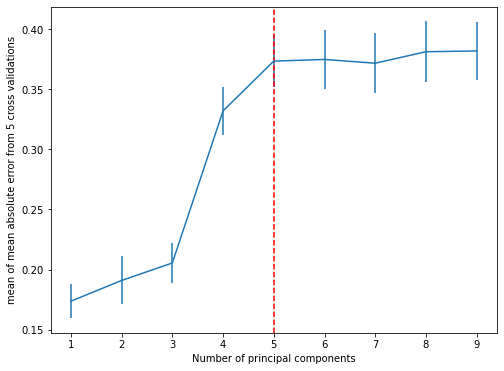

In [41]:
plt.subplots(figsize = (8, 6))
plt.errorbar(n_components, score, yerr=std)
plt.axvline(x = 5, c = 'r', ls = '--')
plt.xlabel('Number of principal components')
plt.ylabel('mean of mean absolute error from 5 cross validations');

It looks like we have a steep increase after 3 components and level off around 5 components. This confirms what we found earlier

In [42]:
best_component = 5

In [43]:
score = []
std = []

for rate in learning_rate:
    cv_results = cross_validate(Pipeline([('scaler', MinMaxScaler()),
                                                            ('pca', PCA(best_component)),
                                                            ('gbr', GradientBoostingRegressor(learning_rate = rate, n_estimators = 300, max_depth = 5))]),
                        x_train, y_train, scoring='r2', cv=5)
    
    score.append(np.mean(cv_results['test_score']))
    std.append(np.std(cv_results['test_score']))

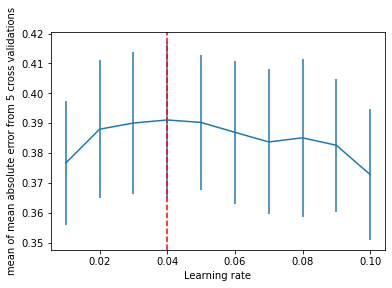

In [44]:
plt.errorbar(learning_rate, score, yerr=std)
plt.axvline(x = 0.04, c = 'r', ls = '--')
plt.xlabel('Learning rate')
plt.ylabel('mean of mean absolute error from 5 cross validations');

The learning rates do not change the score much when they are below 0.1. However, 0.04 produces the highest score so we will choose that value.

In [45]:
best_rate = 0.04

In [46]:
score = []
std = []

for estimator in n_estimators:
    cv_results = cross_validate(Pipeline([('scaler', MinMaxScaler()),
                                                            ('pca', PCA(best_component)),
                                                            ('gbr', GradientBoostingRegressor(learning_rate = best_rate, n_estimators = estimator, max_depth = 5))]),
                        x_train, y_train, scoring='r2', cv=5)
    
    score.append(np.mean(cv_results['test_score']))
    std.append(np.std(cv_results['test_score']))

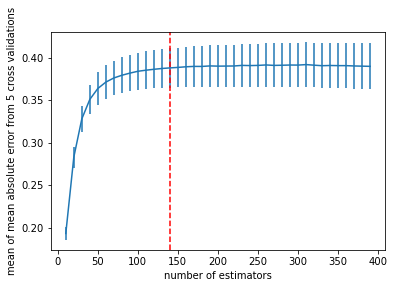

In [47]:
plt.errorbar(n_estimators, score, yerr=std)
plt.axvline(x = 140, c = 'r', ls = '--')
plt.xlabel('number of estimators')
plt.ylabel('mean of mean absolute error from 5 cross validations');

Looks to be leveling off around 140

In [48]:
best_estimator = 140

In [49]:
score = []
std = []

for depth in max_depth:
    cv_results = cross_validate(Pipeline([('scaler', MinMaxScaler()),
                                                            ('pca', PCA(best_component)),
                                                            ('gbr', GradientBoostingRegressor(learning_rate = best_rate, n_estimators = best_estimator, max_depth = depth))]),
                        x_train, y_train, scoring='r2', cv=5)

    score.append(np.mean(cv_results['test_score']))
    std.append(np.std(cv_results['test_score']))

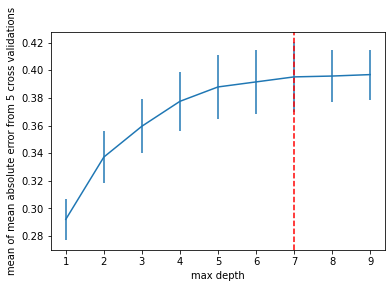

In [50]:
plt.errorbar(max_depth, score, yerr=std)
plt.axvline(x = 7, c = 'r', ls = '--')
plt.xlabel('max depth')
plt.ylabel('mean of mean absolute error from 5 cross validations');

The depth were the score only increases negligibly is 7. We'll use that as our depth parameter. We now have all of the parameters and are ready to do a final cross validation.

In [51]:
best_depth = 7
best_params = {'standardscaler': MinMaxScaler(), 'pca__n_components': best_component,
                                              'gradientboostingregressor__learning_rate': best_rate,
                                             'gradientboostingregressor__n_estimators': best_estimator,
                                             'gradientboostingregressor__max_depth': best_depth}

In [52]:
BestModelGBR = make_pipeline(MinMaxScaler(), PCA(n_components = best_component), GradientBoostingRegressor(learning_rate = best_rate, n_estimators = best_estimator, max_depth = best_depth))

In [53]:
cv_results = cross_validate(BestModelGBR, x_train, y_train, scoring='neg_mean_absolute_error', cv=5)
GBR_train_mae_mean = np.mean(-1 * cv_results['test_score'])
GBR_train_mae_std = np.std(-1 * cv_results['test_score'])
print(GBR_train_mae_mean, GBR_train_mae_std)
BestModelGBR.fit(x_train, y_train)
mean_absolute_error(y_test, BestModelGBR.predict(x_test))

0.06941993500259662 0.0010550538316703134


0.06766334851377438

In [54]:
print(r2_score(y_train, BestModelGBR.predict(x_train)))
print(r2_score(y_test, BestModelGBR.predict(x_test)))

0.6464715210945777
0.40877862932826503


Well we lowered our r2 value for the training set but increased it for the test set. The variance explained by our model is still quite low. Let's visualize our predictions.

#### 10.2 Visualize  <a id='10.2_Visualize'></a>

In [55]:
train_predictions = BestModelGBR.predict(x_train)
test_predictions = BestModelGBR.predict(x_test)
train_df = pd.DataFrame(data = {'train_pred': train_predictions,
                                    'train_act': y_train})
test_df = pd.DataFrame(data = {'test_pred': test_predictions,
                                    'test_act': y_test})
train_df.sort_values(by = 'train_act', ignore_index = True, inplace = True)
test_df.sort_values(by = 'test_act', ignore_index = True, inplace = True)
print(train_df.head())
print(test_df.head())

   train_pred  train_act
0    0.046158        0.0
1    0.045730        0.0
2    0.029809        0.0
3    0.092470        0.0
4    0.072581        0.0
   test_pred  test_act
0   0.135286       0.0
1   0.067458       0.0
2   0.012331       0.0
3   0.183330       0.0
4   0.169323       0.0


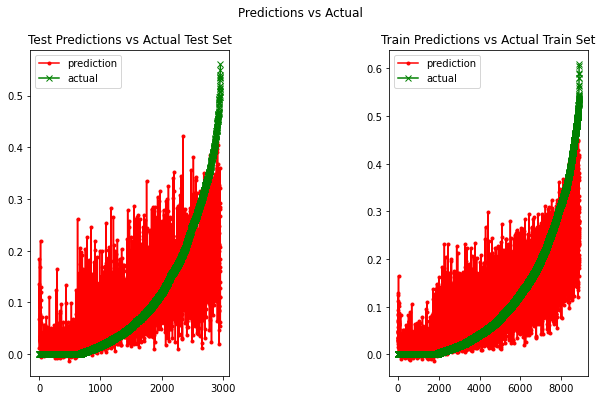

In [56]:
fig, ax = plt.subplots(1, 2, figsize = (10, 6))
plt.subplots_adjust(wspace=0.8, hspace=0.4)

fig.suptitle('Predictions vs Actual')
ax[0].plot(test_df.index, test_df['test_pred'], c = 'r', marker = '.', label = 'prediction')
ax[0].plot(test_df.index, test_df['test_act'], c = 'g', marker = 'x', label = 'actual')
ax[0].set_title('Test Predictions vs Actual Test Set')
ax[0].legend()
ax[1].plot(train_df.index, train_df['train_pred'], c = 'r', marker = '.', label = 'prediction')
ax[1].plot(train_df.index, train_df['train_act'], c = 'g', marker = 'x', label = 'actual')
ax[1].set_title('Train Predictions vs Actual Train Set')
ax[1].legend();

When sorted, our actual values increase exponentialialy. Our predicted values appear to make a more linear progression. Our model seems to overshoot the values for low power generated and undershoot the values for high power generated

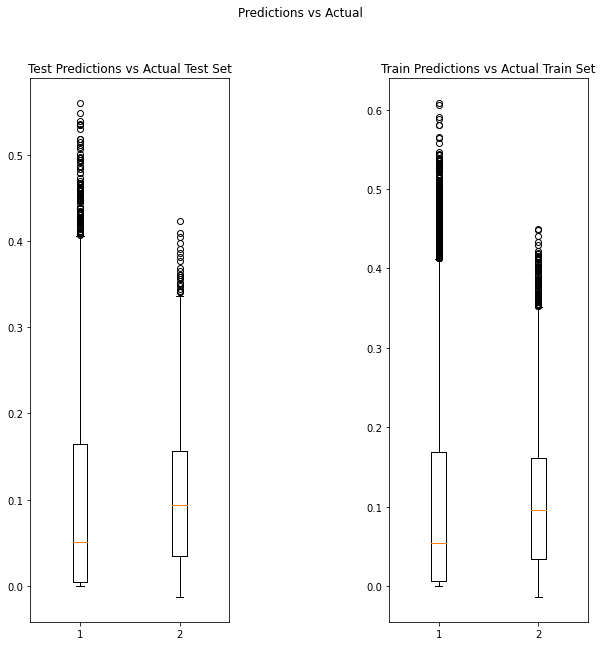

In [57]:
fig, ax = plt.subplots(1, 2, figsize = (10, 10))
plt.subplots_adjust(wspace=0.8, hspace=0.4)

fig.suptitle('Predictions vs Actual')
ax[0].boxplot([test_df['test_act'],test_df['test_pred']])
ax[0].set_title('Test Predictions vs Actual Test Set')
ax[1].boxplot([train_df['train_act'], train_df['train_pred']])
ax[1].set_title('Train Predictions vs Actual Train Set');

#### 10.3 Removing Outliers Remodel  <a id='10.3_Removing_Outliers_Remodel'></a>

Outliers seem to be the bane of our model. the quartiles are fairly close to eachgother. However, with so many outliers on the upper end, our model suffers. How about we see what happens when we remove those outliers from the P_GEN column. Let's make a cut off at the 95 quantile. Let's start over from the original UK_data, remove the outliers, and then make a new train test split.

In [58]:
q = UK_data['P_GEN'].quantile(0.95)

UK_data = UK_data[UK_data['P_GEN'] < q]

UK_data.drop(columns = ['Unnamed: 0', 'Site', 'Humidity_Radiation_ratio', 'WindChill', 'WindRun', 'HeatIndex', 'THWIndex', 'RainRate'], inplace = True)

x = UK_data.drop(columns = ['P_GEN'])
y = UK_data['P_GEN']

x_train2, x_test2, y_train2, y_test2 = train_test_split(x, y, test_size = 0.25)

In [59]:
GBR = make_pipeline(MinMaxScaler(), PCA(n_components = best_component), GradientBoostingRegressor(learning_rate = best_rate, n_estimators = best_estimator, max_depth = best_depth))
GBR.fit(x_train2, y_train2)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('pca', PCA(n_components=5)),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(learning_rate=0.04, max_depth=7,
                                           n_estimators=140))])

In [60]:
mean_absolute_error(y_train2, GBR.predict(x_train2))
mean_absolute_error(y_test2, GBR.predict(x_test2))

0.05555782968608311

In [61]:
print(r2_score(y_train2, GBR.predict(x_train2)))
print(r2_score(y_test2, GBR.predict(x_test2)))

0.6701579185590218
0.4452737562167831


A slight increase! Let's look at a graph again

In [62]:
train_predictions = GBR.predict(x_train)
test_predictions = GBR.predict(x_test)
train_df = pd.DataFrame(data = {'train_pred': train_predictions,
                                    'train_act': y_train})
test_df = pd.DataFrame(data = {'test_pred': test_predictions,
                                    'test_act': y_test})
train_df.sort_values(by = 'train_act', ignore_index = True, inplace = True)
test_df.sort_values(by = 'test_act', ignore_index = True, inplace = True)
print(train_df.head())
print(test_df.head())

   train_pred  train_act
0    0.119280        0.0
1    0.045651        0.0
2    0.031885        0.0
3    0.033796        0.0
4    0.053654        0.0
   test_pred  test_act
0   0.085708       0.0
1   0.011405       0.0
2   0.032013       0.0
3   0.090781       0.0
4   0.032207       0.0


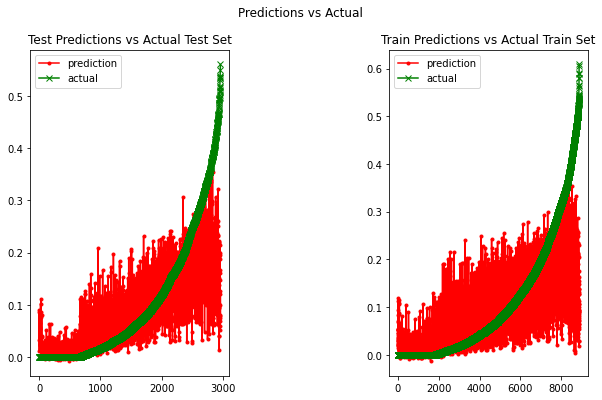

In [63]:
fig, ax = plt.subplots(1, 2, figsize = (10, 6))
plt.subplots_adjust(wspace=0.8, hspace=0.4)

fig.suptitle('Predictions vs Actual')
ax[0].plot(test_df.index, test_df['test_pred'], c = 'r', marker = '.', label = 'prediction')
ax[0].plot(test_df.index, test_df['test_act'], c = 'g', marker = 'x', label = 'actual')
ax[0].set_title('Test Predictions vs Actual Test Set')
ax[0].legend()
ax[1].plot(train_df.index, train_df['train_pred'], c = 'r', marker = '.', label = 'prediction')
ax[1].plot(train_df.index, train_df['train_act'], c = 'g', marker = 'x', label = 'actual')
ax[1].set_title('Train Predictions vs Actual Train Set')
ax[1].legend();

I think it would be a good idea to proceed with the outliers removed. Our model improved by about 10% in the r2 score after removing them.

### 11 Saving the Model  <a id='10_Saving_the_Model'></a>

In [64]:
best_model = BestModelGBR
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in x_train.columns]
best_model.build_datetime = datetime.datetime.now()

In [65]:
modelpath = '../models'
save_file(best_model, 'power_predictor.pkl', modelpath)

A file already exists with this name.

Do you want to overwrite? (Y/N)y
Writing file.  "../models/power_predictor.pkl"


In [66]:
datapath = '../data'
save_file(y_train2, 'Y_train2.csv', datapath)
save_file(x_train2, 'X_train2.csv', datapath)

A file already exists with this name.

Do you want to overwrite? (Y/N)y
Writing file.  "../data/Y_train2.csv"
A file already exists with this name.

Do you want to overwrite? (Y/N)y
Writing file.  "../data/X_train2.csv"


### 12 Conclusion<a id='11_Conclusion'></a>

The model that performed the best out of the four that we tried was gradient boosting regression. The best parameters were; max depth of six, 77 estimators, MinMaxScaler, nine principal components, and learning rate of 0.1. Our models did not perform ideally, producing fairly low r2 values. The data was collected for a different purpose than it is being used for here. As a result, data integrity and accuracy are hard to determine for our features. Although we got a low r2 score for our model, we can clearly see that it performs better than the mean and shows a relationship between our explanatory features and our response variable. 

To improve the model, I believe some more explanatory features are needed. For instance, a measure of cloud cover is certainly very important to knowing how much solar radiation will be available to the solar panels. Also, we do not know if our different sites had solar panels that we installed the same way. With movement or stationary? If stationary, which direction is it facing?

Our model does not perform at the level of a commercial product, by any means. However, the relationship between variables and outcome is clearly observed. We can revisit when we have more data